In [205]:
%matplotlib inline

import csv
import numpy as np 
import scipy as sp
import pandas as pd
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

In [206]:
PATH = "./movies_csv/"
NUM_OBS = 500

PLOT_DISABLE = 0
PLOT_ENABLE = 1

In [207]:
def getData(file):
    reader=csv.reader(open(file,"rb"),delimiter=',')
    x=list(reader)
    result=np.array(x).astype(np.float32)
    return result

In [208]:
def genC(n, w):
	w_cumul	= w.cumsum()
	c	= np.zeros((1,n))
	w_arr	= pd.Series(w_cumul)
	c 	= [w_arr[(w_arr > np.random.random())].index[0] for i in range(0,n)]		
	return c

In [209]:
def euclid(a,b):
    return np.linalg.norm(a-b)

In [210]:
def kmeans(x, k, iter_num, plot_req):
    ## Function takes inputs:
    ## x --> input data & k--> k value & iter_num --> number of iterations
    ## Returns:
    ## c --> cluster assignment, 
    ## mu--> mean of classes
    ## L --> Objective function value
    d = np.size(x,axis=1)
    n = np.size(x,axis=0)
    mu = np.random.rand(d,k) # 2xk in our case.
    c = np.zeros((n,1))
    L = np.zeros((1,iter_num))
    #print d,n
    
    #int_res = []  # Intermediate x-mu values for all mu.
    
    for i in range(0,iter_num):
            sum = 0
            temp_sum = np.zeros((d,k)) # holds summation xi (c=k)
            n_k = np.zeros(k) #holds nk
            for j in range(0,n):
                int_res = [euclid(x[j,:], mu[:,m])**2 for m in range(0,k)]
                c[j][0] = np.argmin(int_res)
                sum = sum + np.min(int_res)
                allo_k = int(c[j][0])
                n_k[allo_k] = n_k[allo_k]+1
                temp_sum[:,allo_k] = temp_sum[:,allo_k] + x[j,:]
            mu = temp_sum*1.0/n_k    
                
            L[0][i] = L[0][i-1] if np.isnan(sum) else sum 
    if (plot_req):        
        plt.clf()
        plt.scatter(x[:,0], x[:,1], c=c*500)
        plt.plot(mu[0,:],mu[1,:], 'rx')
        plt.title("Scatter plot for k=%d"%k)
        plt.savefig("./images/k_means_scatter_plot_k=%d.jpg"%k)
        plt.show()
    return c, mu , L

In [211]:
def part1():
    print "Running K-means."
    pi = np.array([0.2, 0.5, 0.3])
    c = genC(NUM_OBS,pi)
    mu = [[0,0],[3,0],[0,3]]
    sig = [[[1,0],[0,1]],
          [[1,0],[0,1]],
          [[1,0],[0,1]]]
    n = np.zeros(np.size(pi))
    samples = []
    for i in range(0,len(n)):
        n[i] = sum([elem==i for elem in c])
        samples=samples+list(np.random.multivariate_normal(mean =mu[i], cov=sig[i], size=int(n[i])))
    samples = np.array(samples)
    #print samples
    
    k_val = [2,3,4,5,6]
    L_list = []
    mu_list = []
    c_list = []
    for k in k_val:
        print "k=%d" %k
        c, mu , L = kmeans(samples, k, 20, PLOT_ENABLE)
        c_list.append(c)
        mu_list.append(mu)
        L_list.append(L)
        #print L
    #print L_list
    
    plt.clf()
    for idx,L in enumerate(L_list):
    #    print str(idx+2) +":"
    #    print (L[0])
        
        plt.plot(L[0], label="L=%d"%(idx+2))
    
    plt.xlabel("Iteration Number")
    plt.ylabel("L values")
    plt.title("Plot of Objective Functions")
    plt.legend(loc='upper right', shadow=True)
    plt.savefig("./images/k_means_L_plot.jpg")
    plt.show()
    
    

In [212]:
def map_infer(M_train, M_test, u, v, lam, var, num_iter):
    
    N1 = np.size(u, axis=0) #N1-->number of users 
    N2 = np.size(v, axis=0) #N2-->number of movies
    d  = np.size(u, axis=1) #d --> rank of matrix
    
    L_list = []
    err_list = []
    
    iden = lam*var*np.eye(d)
    
    j_train = findIdx(M_train)
    i_train = findIdx(M_train.T)

    j_test = findIdx(M_test)
    i_test = findIdx(M_test.T)

    M_train = remZero(M_train)
    M_test = remZero(M_test)
    print M_train
    for iter_number in range(0,num_iter):    
        # Update u
        print iter_number
        for i in range(0,N1):
            #u_i = u[i,:]
            tem = 0

            term_1 = iden
            term_3 = np.zeros(d)
            term_2 = np.zeros((d,d))

            for j in j_train[i]:
                    #print "j:"
                    #print j
                    M_ij = M_train[i,j]
                    v_j = v[j,:].T
                    term_2 = term_2 + np.dot(v_j,v_j.T)
                    term_3 = term_3 + (M_ij*v_j)
            u[i,:] = np.dot(np.linalg.pinv(term_1+term_2), term_3)
#            u[i,:] = np.dot(np.linalg.inv(iden+np.dot(v[:,j_train[i]].reshape(d,len(j_train[i])),v[:,j_train[i]].reshape(d,len(j_train[i])).T)),np.dot(v[:,j_train[i]].reshape(d,len(j_train[i])),user_score[i])).reshape(1,d)        
    
    # Update each v vector
    for j in range(0,N2):
        v[:,j] = np.dot(np.linalg.inv(iden+np.dot(u[i_train[j],:].reshape(d,len(i_train[j])),u[i_train[j],:].reshape(d,len(i_train[j])).T)),np.dot(u[i_train[j],:].reshape(d,len(i_train[j])),film_score[j])).reshape(d,)

        # Update v
        for j in range(0,N2):
            #u_i = u[i,:]
            tem = 0
            term_1 = iden
            term_3 = np.zeros(d)
            term_2 = np.zeros((d,d))

            for i in i_train[j]:
                    #print "j:"
                    #print j
                    M_ij = M_train[i,j]
                    u_i = u[i,:].T
                    term_2 = term_2 + np.dot(u_i,u_i.T)
                    term_3 = term_3 + (M_ij*u_i)
            #v[j,:] = np.dot(np.linalg.pinv(term_1+term_2), term_3)
            v[:,j] = np.dot(np.linalg.inv(iden+np.dot(u[i_train[j],:].reshape(d,len(i_train[j])),u[i_train[j],:].reshape(d,len(i_train[j])).T)),np.dot(u[i_train[j],:].reshape(d,len(i_train[j])),film_score[j])).reshape(d,)

        M_train = checkM(np.round(np.dot(u,v.T)))
        
        error = []
        for i in range(0,N1):
            for j in j_test[i]:
                    error.append(M_train[i,j] - M_test[i,j])
        err_list.append(rmse(error))    
        L_list.append(calcL(u, v, M_train, j_train, lam, var))
        print err_list[-1]
        print L_list[-1]
        #print M_train
    return L_list, err_list, u, v

In [213]:
def remZero(M):
    for i,row in enumerate(M):
        for j,col in enumerate(row):
            if M[i,j]==0:
                M[i,j] = 0
                #M[i,j]=np.random.randint(1,6,1)[0]
    return M

In [215]:
def rmse(array):
    return np.sqrt(np.mean(np.array(array)**2))

In [217]:
def checkM(M):
    for i,row in enumerate(M):
        for j,col in enumerate(row):
            if M[i,j]<1:
                M[i,j]=1
            elif M[i,j]>5:
                M[i,j]=5
    return M

In [218]:
def findIdx(matrix):
    idx_arr=[]
    for idx,row in enumerate(matrix):
        tem_list=[]
        for i,col in enumerate(row):
            if col != 0:
                tem_list.append(i)
        idx_arr.append(tem_list)
    return idx_arr

In [278]:
def calcLL(u, v, y_calc, y_train, lam, var):
    N1 = np.size(u, axis=0) #N1-->number of users 
    N2 = np.size(v, axis=0) #N2-->number of movies
    d  = np.size(u, axis=1) #d --> rank of matrix
    
    lnpUi = -(lam / 2.0) * (u ** 2).sum(axis=1).sum()
    lnpVj = -(lam / 2.0) * (v ** 2).sum(axis=1).sum()
    
    lnMij = 0.5/var * ((y_calc-y_train)**2).sum()

    #for i in range(0,N1):
    #    for idx,ind in enumerate(i_train[i]):
    #            lnMij= lnMij + (0.5/var*((M[i,j]-u_v[i,j])**2))
    
    L= -(lnMij + lnpUi + lnpVj)
    return L

In [279]:
def main():
    #part1()
    part2()

In [280]:
def part2():
    X_train = np.genfromtxt("./movies_csv/ratings.txt", delimiter=',', dtype='int32')
    X_test = np.genfromtxt("./movies_csv/ratings_test.txt", delimiter=',', dtype='int32')
    label = np.genfromtxt("./movies_csv/movies.txt", dtype='string', delimiter='\n')
    
    NUM_ITER = 20
    
    # creating an (i,j)
    
    X_train[:,0:2]= X_train[:,0:2]-1
    X_test[:,0:2]= X_test[:,0:2]-1
    y_train = X_train[:,2]
    y_test = X_test[:,2]
    
    N1 = np.max(X_train[:,0]) + 1 # max user id
    N2 = np.max(X_train[:,1]) + 1# max movie id
    
    d   = 10
    lam = 10
    var = 0.25
    
    iden = lam * var * np.eye(d)
    
    ## Generate the j_train: User ID's for each user who rated the film j
    ## & film_rating by that user
    j_train = []
    film_rating = []
    for j in range(0,N2):   # iterate through each movie
            idx = np.argwhere(X_train[:,1]== j)
            j_train.append(X_train[idx,0])
            film_rating.append(X_train[idx,2])            
                
    ## Generate the i_train: Film ID's for each film rated by user i
    ## & user_rating for all films
    i_train = []
    user_rating = []
    for i in range(0,N1):   # iterate through each user
            idx = np.argwhere(X_train[:,0]== i)
            i_train.append(X_train[idx,1])
            user_rating.append(X_train[idx,2])            
    
    
    v = np.random.multivariate_normal(mean =np.zeros(d), cov=(1.0/lam)*np.eye(d), size=N2)
    u = np.random.multivariate_normal(mean =np.zeros(d), cov=(1.0/lam)*np.eye(d), size=N1)
    
    err_list = []
    L_list = []
    for iteration in range(0,NUM_ITER):
        print "%d th iteration"%iteration
        
        for i in range(0,N1):
            #print i
            term1 = iden
            term2 = np.zeros((d,d))
            for ind in i_train[i]:
                term2 = term2 + np.dot(v[ind,:].T,v[ind,:])
            term3 = np.zeros(d)
            for idx,ind in enumerate(i_train[i]):
                #print ind
                term3 = term3 + np.dot(user_rating[i][idx],v[ind,:])
            u[i,:] = np.dot(np.linalg.inv(term1+term2),term3)
            
            
        for j in range(0,N2):
            term1 = iden
            term2 = np.zeros((d,d))
            term3 = np.zeros(d)
            
            for ind in j_train[j]:
                term2 = term2 + np.dot(u[ind,:].T,u[ind,:])
            for idx,ind in enumerate(j_train[j]):
                term3 = term3 + np.dot(film_rating[j][idx],u[ind,:])
            v[j,:] = np.dot(np.linalg.inv(term1+term2),term3)
                
        u_v = np.dot(u,v.T)
        y_pred = np.round(u_v[X_test[:,0],X_test[:,1]])
        
        err_list.append(rmse(y_pred - y_test))
       
        L_list.append(calcLL(u, v, np.round(u_v[X_train[:,0],X_train[:,1]]), y_train,lam,var))

    plt.clf()
    plt.plot(err_list)
    plt.savefig("./images/rmse_plot.jpg")
    plt.show()
    
    plt.clf()
    plt.plot(L_list)
    plt.savefig("./images/LL_plot.jpg")
    plt.show()

0 th iteration
1 th iteration
2 th iteration
3 th iteration
4 th iteration
5 th iteration
6 th iteration
7 th iteration
8 th iteration
9 th iteration
10 th iteration
11 th iteration
12 th iteration
13 th iteration
14 th iteration
15 th iteration
16 th iteration
17 th iteration
18 th iteration
19 th iteration


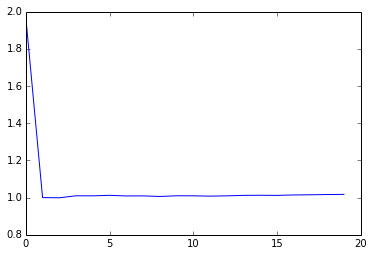

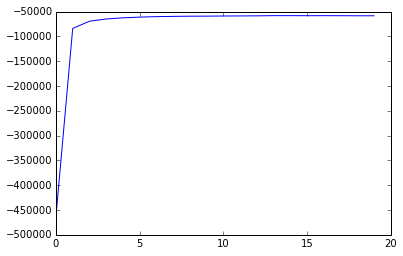

In [281]:
main()